Ce code met en œuvre une chaîne complète de communication en mode half‑duplex intégrant à la fois l’émission et la réception d’un message, ainsi que l’envoi et la réception d’un accusé de réception (ACK). Il combine plusieurs techniques de traitement et de modulation du signal, notamment le calcul du CRC, la construction de trames, le codage Manchester, la modulation en ASK et FSK, la sauvegarde dans divers formats (CSV, WAV mono et stéréo) et enfin la démodulation et le décodage pour reconstituer le message. Voici une description détaillée du fonctionnement du code, section par section :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io.wavfile import write  # Pour sauvegarder en WAV

plt.style.use('ggplot')


---

## 1. Configuration et Paramètres Globaux

- **Importations et style graphique :**  
  - Utilisation de `numpy` pour les opérations numériques.
  - `matplotlib.pyplot` pour la visualisation (avec le style "ggplot").
  - `sounddevice` pour la lecture audio.
  - `scipy.io.wavfile.write` pour sauvegarder les signaux modulés au format WAV.
  
- **Paramètres globaux définis :**
  - `Fe = 44100` Hz : fréquence d’échantillonnage.
  - `baud = 200` bits/s : débit binaire.
  - `Ns = int(Fe/baud)` (~220) : nombre d’échantillons par bit.
  - Pour la modulation, deux types de porteuses sont définis :
    - **ASK :** fréquence de 2000 Hz.
    - **FSK :** 200 Hz pour représenter un bit 1 et 3000 Hz pour représenter un bit 0.

---

In [2]:
###############################################################################
#                   PARAMÈTRES GLOBAUX
###############################################################################
Fe   = 44100        # Fréquence d'échantillonnage
baud = 200          # Débit binaire
Ns   = int(Fe/baud) # Nombre d'échantillons par bit (~220)
Fp_ASK = 2000
fp1    = 200
fp2    = 3000

# Justification du choix des paramètres pour la transmission numérique basée sur ASK et FSK

Dans cette implémentation d'un système de communication numérique, les paramètres choisis sont optimisés pour assurer une transmission robuste et facilement démodulable tout en maintenant une complexité raisonnable. Voici une analyse détaillée des décisions prises.

---

## 1. Fréquence d’échantillonnage
**`Fe = 44100 Hz`**  

### ✅ Justification théorique :
- La **théorie de l’échantillonnage de Nyquist-Shannon** impose que la fréquence d’échantillonnage soit au moins **deux fois supérieure à la fréquence maximale du signal transmis** pour éviter le repliement spectral (*aliasing*).
- En considérant que la fréquence porteuse la plus haute utilisée est **3000 Hz (FSK)**, un minimum de **6000 Hz** suffirait.
- Cependant, **44,1 kHz** a été choisi car il s'agit d'une fréquence d’échantillonnage standard en traitement audio numérique.  
  Cela simplifie la gestion des fichiers audio (`WAV`) et permet une compatibilité avec du matériel existant.

---

## 2. Débit binaire
**`baud = 200`**  

### ✅ Justification technique :
- Un débit binaire de **200 bits/s** assure un bon compromis entre **vitesse de transmission et robustesse du signal**.
- Un débit plus élevé nécessiterait une bande passante plus large et **rendrait la synchronisation plus complexe**.
- Un débit plus faible améliorerait la robustesse mais **ralentirait excessivement la transmission**.
- Avec **200 bauds**, chaque bit a une durée de **5 ms**, ce qui est suffisant pour garantir une distinction nette entre les transitions du signal et permettre une démodulation efficace.

---

## 3. Nombre d’échantillons par bit
**`Ns = Fe / baud = 44100 / 200 = 220`**  

### ✅ Explication mathématique :
- Chaque bit est représenté par **220 échantillons**, garantissant une résolution temporelle suffisante pour capturer les variations du signal modulé.
- **Pourquoi ne pas prendre une valeur plus basse ?**
  - Une valeur trop faible compliquerait la démodulation, car il y aurait **moins d’échantillons pour détecter correctement la présence du signal**.
- **Pourquoi ne pas prendre une valeur plus haute ?**
  - Une valeur trop élevée augmenterait inutilement **le volume des données à traiter** sans réel gain en précision.

Ce choix garantit donc un **échantillonnage dense** sans surcharge computationnelle excessive.

---

## 4. Fréquence de la porteuse en modulation ASK
**`Fp_ASK = 2000 Hz`**  

### ✅ Critères de sélection :
- La fréquence porteuse ASK doit être **suffisamment élevée** pour bien distinguer les transitions binaires tout en étant **facile à générer et à détecter**.
- **Pourquoi 2000 Hz ?**
  - Elle est **significativement supérieure au débit binaire (200 Hz)**, ce qui facilite la détection du signal modulé.
  - Elle reste bien en dessous de la **limite de Nyquist (Fe/2 = 22050 Hz)**, garantissant une transmission sans aliasing.
  - Elle **minimise la diaphonie et les interférences** avec les composantes basse fréquence du signal.

---

## 5. Fréquences de modulation FSK
**`fp1 = 200 Hz, fp2 = 3000 Hz`**  

### ✅ Justification par le spectre fréquentiel :
- La **modulation FSK** repose sur l’alternance entre **deux fréquences bien distinctes** pour coder les états binaires :  
  - **fp1 = 200 Hz** pour le bit `0`
  - **fp2 = 3000 Hz** pour le bit `1`
  
- **Pourquoi ces valeurs spécifiques ?**
  - **Un faible fp1 (200 Hz)** assure une modulation bien différenciée sans perturber les composantes continues du signal.
  - **Un fp2 plus élevé (3000 Hz)** permet une **séparation spectrale nette** entre les deux états logiques, ce qui simplifie la démodulation par filtrage fréquentiel.
  - L’écart de **2800 Hz** entre les deux fréquences garantit une distinction claire, facilitant la détection du changement d’état dans un environnement bruité.

Ce choix garantit une **démodulation efficace** tout en minimisant les interférences.

---

## 2. Partie ÉMISSION

Cette partie prépare le message à émettre en passant par plusieurs étapes de traitement.

### a) Calcul du CRC – `crcemission(bits)`

- **Objectif :**  
  Pour chaque octet (8 bits) du message, ajouter 4 bits de redondance calculés via un algorithme de CRC utilisant le diviseur binaire `"1001"` (équivalent à 9 en décimal).
- **Fonctionnement :**
  - Le message est découpé par tranche de 8 bits.
  - Pour chaque tranche, on ajoute "0000" à la fin, on convertit le tout en entier, puis on divise par le diviseur afin d’obtenir le reste.
  - Le résultat est constitué de l’octet original suivi du reste (4 bits) et est renvoyé sous forme de liste de bits.

### b) Construction de la Trame – `trame_emission(bits, type_fichier="txt")`

- **Objectif :**  
  Encapsuler le message dans une trame qui comporte :
  - Un **fanion de début** (8 bits à 1, soit `[1,1,1,1,1,1,1,1]`).
  - Un **octet de protocole** indiquant le type de fichier (pour le texte, `[1,1,0,0,0,0,1,1]` est utilisé).
  - Les données (bits avec CRC).
  - Un **fanion de fin** (8 bits à 0, soit `[0,0,0,0,0,0,0,0]`).

### c) Codage Manchester – `Manchester_encode(bits)`

- **Principe :**  
  Chaque bit est transformé en deux bits selon la règle suivante :
  - Si le bit vaut 1 → il devient la paire (1,0).
  - Si le bit vaut 0 → il devient la paire (0,1).

- **Utilité :**  
  Le codage Manchester facilite la synchronisation et la détection d’erreurs lors de la transmission.

### d) Modulation ASK et FSK – `modulation_ASK_FSK(bits_manchester, filename_prefix="Message")`

- **Duplication temporelle des bits :**  
  La séquence Manchester est étendue en répétant chaque bit `Ns` fois afin d’obtenir la bonne résolution temporelle pour la modulation.

- **Création des signaux modulés :**
  - **ASK :**  
    - Une porteuse sinusoïdale à 2000 Hz est générée.
    - Le signal binaire dupliqué module l’amplitude de cette porteuse (multiplication élément par élément).
  - **FSK :**  
    - Deux sinusoïdes sont générées à 200 Hz et 3000 Hz.
    - La fonction `np.where` sélectionne, pour chaque échantillon, la sinusoïde correspondant à la valeur du bit (1 ou 0).

- **Sauvegarde des signaux :**
  - Les signaux modulés sont enregistrés dans des fichiers CSV.
  - Ils sont également sauvegardés en fichiers WAV mono (pour ASK et FSK) et en un fichier WAV stéréo, où le canal gauche contient le signal ASK et le canal droit le signal FSK.

- **Lecture audio et visualisation :**
  - Les signaux (ASK, FSK et stéréo) sont lus via `sounddevice`.
  - Des graphiques (zoom sur les 2000 premiers échantillons) permettent de visualiser :
    - Le signal binaire dupliqué.
    - Le signal ASK.
    - Le signal FSK.

---

In [3]:
###############################################################################
#                   ÉMISSION : CRC, TRAME, MANCHESTER, MODULATION
###############################################################################

def crcemission(bits):
    """
    Calcule et ajoute 4 bits de CRC pour chaque octet (diviseur '1001').
    """
    diviseur = int("1001", 2)
    resultat_crc = []
    local_bits = bits[:]
    while len(local_bits) >= 8:
        donne_str = ''.join(map(str, local_bits[:8]))
        local_bits = local_bits[8:]
        # Ajout de 4 zéros
        div_str = donne_str + "0000"
        div_int = int(div_str, 2)
        _, reste = divmod(div_int, diviseur)
        # On remet l'octet et le reste
        resultat_crc.extend(map(int, donne_str))
        resultat_crc.extend(map(int, format(reste, '04b')))
    return resultat_crc

def trame_emission(bits, type_fichier="txt"):
    """
    Construit la trame :
      - fanion de début : 11111111
      - octet de protocole (ex : 11000011 pour txt)
      - bits + CRC
      - fanion de fin : 00000000
    """
    fanion_debut = [1]*8
    fanion_fin   = [0]*8
    # Ex : protocole "txt" = [1,1,0,0,0,0,1,1]
    prot_txt = [1,1,0,0,0,0,1,1] if type_fichier=="txt" else [0,0,0,0,0,0,0,0]

    return fanion_debut + prot_txt + bits + fanion_fin

def Manchester_encode(bits):
    """
    1 -> (1,0)
    0 -> (0,1)
    """
    code = []
    for b in bits:
        if b == 1:
            code.extend([1,0])
        else:
            code.extend([0,1])
    return code

def modulation_ASK_FSK(bits_manchester, filename_prefix="Message"):
    """
    Génère 2 signaux (ASK, FSK), enregistre dans 2 CSV, 2 WAV mono et 1 WAV stéréo,
    puis les lit en audio.
    
    bits_manchester : liste binaire codée Manchester
    filename_prefix : "Message" ou "ACK", etc. pour distinguer les fichiers.
    """
    # Duplication des bits pour correspondre à la durée (Ns échantillons par bit)
    bits_dupliques = np.repeat(bits_manchester, Ns)
    N = len(bits_dupliques)
    t = np.arange(N) / Fe

    # Génération de la porteuse ASK
    porteuse = np.sin(2 * np.pi * Fp_ASK * t)
    ASK = bits_dupliques * porteuse

    # Modulation FSK
    s1 = np.sin(2 * np.pi * fp1 * t)
    s2 = np.sin(2 * np.pi * fp2 * t)
    FSK = np.where(bits_dupliques == 1, s1, s2)

    # Sauvegarde dans des fichiers CSV
    ask_csv_file = f"{filename_prefix}_ASK.csv"
    fsk_csv_file = f"{filename_prefix}_FSK.csv"
    np.savetxt(ask_csv_file, ASK, fmt='%.6f', delimiter=',')
    np.savetxt(fsk_csv_file, FSK, fmt='%.6f', delimiter=',')

    # Sauvegarde en fichiers WAV mono (normalisés en float32)
    ask_wav_file = f"{filename_prefix}_ASK.wav"
    fsk_wav_file = f"{filename_prefix}_FSK.wav"
    write(ask_wav_file, Fe, ASK.astype(np.float32))
    write(fsk_wav_file, Fe, FSK.astype(np.float32))

    # Création d'un signal stéréo : canal gauche = ASK, canal droit = FSK
    stereo_signal = np.column_stack((ASK, FSK))
    stereo_wav_file = f"{filename_prefix}_stereo.wav"
    write(stereo_wav_file, Fe, stereo_signal.astype(np.float32))

    # Lecture audio des signaux mono
    print(f"Lecture audio du signal ASK ({ask_csv_file} et {ask_wav_file})")
    sd.play(ASK, Fe)
    sd.wait()
    print(f"Lecture audio du signal FSK ({fsk_csv_file} et {fsk_wav_file})")
    sd.play(FSK, Fe)
    sd.wait()

    # Lecture audio du signal stéréo
    print(f"Lecture audio du signal stéréo ({stereo_wav_file})")
    sd.play(stereo_signal, Fe)
    sd.wait()

    # Graphiques (optionnel, zoom sur 2000 échantillons)
    plt.figure(figsize=(10, 3))
    plt.plot(t[:2000], bits_dupliques[:2000], color='blue', label='Bits dupliqués (Manchester)')
    plt.title(f"{filename_prefix}: bits (zoom 2000)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10, 3))
    plt.plot(t[:2000], ASK[:2000], color='red', label='ASK')
    plt.title(f"{filename_prefix}: ASK (zoom 2000)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(10, 3))
    plt.plot(t[:2000], FSK[:2000], color='green', label='FSK')
    plt.title(f"{filename_prefix}: FSK (zoom 2000)")
    plt.legend()
    plt.grid(True)

    plt.show()


## 3. Partie RÉCEPTION

Cette partie traite la réception des signaux pour en extraire et décoder le message.

### a) Démodulation – `demodulation_ASK_FSK(filename_prefix="Message")`

- **Lecture des fichiers CSV :**  
  Les signaux modulés sont relus depuis les fichiers CSV générés lors de l’émission.
  
- **Démodulation de la voie ASK :**
  - La même porteuse utilisée lors de l’émission est générée.
  - Le signal ASK reçu est multiplié par la porteuse.
  - Pour chaque bit (délimité par un bloc de `Ns` échantillons), une intégration numérique (via `np.trapz`) est effectuée pour décider si le bit démodulé est 1 (si l’intégrale est positive) ou 0.

### b) Décodage Manchester – `Manchester_decode(bits)`

- **Fonctionnement :**  
  Le décodage consiste à parcourir la séquence par paires de bits :
  - La paire (1,0) est interprétée comme un 1.
  - La paire (0,1) est interprétée comme un 0.
  - Les autres motifs sont ignorés (ou pourraient signaler une erreur).

### c) Extraction de la Trame – `trame_reception(bits)`

- **Objectif :**  
  Retirer les fanions de début et de fin, extraire l’octet de protocole et isoler la partie contenant les données et le CRC.
- **Vérifications :**
  - Le fanion de début doit être 8 bits à 1.
  - Le fanion de fin doit être 8 bits à 0.
  - L’octet de protocole (dans ce cas, `[1,1,0,0,0,0,1,1]` pour un message texte) est utilisé pour identifier le type de fichier.

### d) Vérification du CRC – `crcreception(bits)`

- **Processus :**  
  - Les données sont traitées par blocs de 12 bits (8 bits de données suivis de 4 bits de CRC).
  - Pour chaque bloc, le CRC est recalculé (en ajoutant "0000" à l’octet et en divisant par 9) puis comparé aux 4 bits reçus.
  - Si tous les blocs passent la vérification, la fonction renvoie la séquence de données (sans le CRC) ; sinon, elle renvoie `None` pour signaler une erreur.

### e) Décodage ASCII – `ASCII_decode(bits, type_fic)`

- **Objectif :**  
  Reconvertir la séquence binaire (groupée par 8 bits) en caractères ASCII afin de reconstituer le message.
- **Processus :**  
  Chaque groupe de 8 bits est converti en entier, puis en caractère (via `chr`), et assemblé dans une chaîne de caractères.

---

In [4]:
###############################################################################
#                     RÉCEPTION : DÉMODULATION, DÉCODAGE
###############################################################################

def demodulation_ASK_FSK(filename_prefix="Message"):
    """
    Lit 2 CSV (ASK et FSK), démodule la voie ASK.
    """
    ask_file = f"{filename_prefix}_ASK.csv"
    fsk_file = f"{filename_prefix}_FSK.csv"

    ASK_signal = np.genfromtxt(ask_file, delimiter=',')
    FSK_signal = np.genfromtxt(fsk_file, delimiter=',')

    N = len(ASK_signal)
    t = np.arange(N) / Fe
    # Démodulation ASK : multiplication par la porteuse et intégration par bit
    porteuse = np.sin(2 * np.pi * Fp_ASK * t)
    produit  = ASK_signal * porteuse
    bits = []
    for i in range(0, N, Ns):
        portion = produit[i:i+Ns]
        val = np.trapz(portion)
        bits.append(1 if val > 0 else 0)

    return bits

def Manchester_decode(bits):
    """
    Récupère 1 bit sur chaque paire (1,0) -> 1, (0,1) -> 0.
    """
    decode = []
    for i in range(0, len(bits), 2):
        b1 = bits[i]
        b2 = bits[i+1]
        if (b1, b2) == (1, 0):
            decode.append(1)
        elif (b1, b2) == (0, 1):
            decode.append(0)
        # Si motif inconnu, il est ignoré.
    return decode

def trame_reception(bits):
    """
    Extrait fanion début (11111111), fanion fin (00000000), octet protocole, data+CRC.
    Retourne data_crc, type_fichier.
    """
    if len(bits) < 16:
        return None, None
    fanion_debut = bits[:8]
    fanion_fin   = bits[-8:]
    core = bits[8:-8]

    if fanion_debut != [1] * 8 or fanion_fin != [0] * 8:
        return None, None

    if len(core) < 8:
        return None, None

    protocole = core[:8]
    data_crc  = core[8:]
    type_fic = "txt" if protocole == [1,1,0,0,0,0,1,1] else "?"
    return data_crc, type_fic

def crcreception(bits):
    """
    Lit par blocs de 12 bits : 8 data + 4 CRC.
    Diviseur '1001' (9).
    """
    diviseur = int("1001", 2)
    idx = 0
    data_res = []
    integrite_ok = True
    while idx + 12 <= len(bits):
        bloc = bits[idx:idx+12]
        idx += 12
        data_8 = bloc[:8]
        reste_4 = bloc[8:]
        # Recalcul du CRC
        data_str = ''.join(map(str, data_8))
        data_plus_0000 = data_str + "0000"
        data_dec = int(data_plus_0000, 2)
        reste_calc = data_dec % diviseur
        reste_str  = format(reste_calc, '04b')
        recu_str   = ''.join(map(str, reste_4))
        if reste_str != recu_str:
            integrite_ok = False
        data_res.extend(data_8)
    if integrite_ok:
        return data_res
    else:
        return None

def ASCII_decode(bits, type_fic):
    """
    8 bits -> 1 char, reconstruit la chaîne ASCII.
    """
    if type_fic != "txt" or not bits:
        return "[Protocole inconnu ou bits vides]"
    chaine = ""
    for i in range(0, len(bits), 8):
        octet = bits[i:i+8]
        if len(octet) < 8:
            break
        val = int(''.join(map(str, octet)), 2)
        chaine += chr(val)
    return chaine


## 4. Chaîne Half‑Duplex avec ACK – `send_message_and_receive_ack()`

Cette fonction orchestre l’ensemble du processus de communication en mode half‑duplex et se divise en quatre phases :

### Phase 1 : Émission du message
- **Saisie et conversion :**  
  L’utilisateur saisit un message qui est converti en binaire (8 bits par caractère).
- **Traitement :**  
  Le message subit le calcul du CRC, la construction de la trame et l’encodage Manchester.
- **Modulation :**  
  La chaîne de bits est modulée en ASK et FSK, et les signaux sont sauvegardés (CSV, WAV mono et stéréo) puis joués.

### Phase 2 : Réception du message
- **Démodulation et décodage :**  
  Le signal ASK est relu à partir du fichier CSV, démodulé (multiplication par la porteuse et intégration par bit), puis décodé du Manchester.
- **Extraction de la trame et vérification du CRC :**  
  On récupère les données utiles et on vérifie l’intégrité via le CRC.
- **Reconstitution du message :**  
  La partie ASCII est reconstituée à partir des bits de données validés, et le message final est affiché.

### Phase 3 : Émission de l’ACK
- **Préparation d’un ACK :**  
  Un message d’accusé de réception (ici "OK") est traité de la même manière (conversion en binaire, ajout du CRC, construction de la trame, encodage Manchester).
- **Modulation et enregistrement :**  
  Les signaux ACK (ASK et FSK) sont générés, sauvegardés et joués.

### Phase 4 : Réception de l’ACK
- **Démodulation et décodage de l’ACK :**  
  Le signal ACK est démodulé et décodé (similaire à la réception du message).
- **Validation :**  
  Après extraction de la trame et vérification du CRC, l’ACK final est reconstruit en ASCII et affiché.

---

In [5]:
###############################################################################
#                   HALF-DUPLEX AVEC ACK
###############################################################################

def send_message_and_receive_ack():
    """
    1) L'utilisateur saisit un message.
    2) On émet (CRC, trame, Manchester, modulation ASK/FSK).
    3) Le "Receiver" démodule, décode et reconstruit l'ASCII.
    4) Si tout est correct, le Receiver émet un ACK (message "OK").
    5) Le "Sender" reçoit cet ACK.
    """
    #### ÉMISSION DU MESSAGE ####
    print("=== PHASE 1 : ÉMISSION DU MESSAGE ===")
    texte = ""
    while not texte:
        texte = input("Saisissez votre message (5-10 caractères) :\n")

    # Conversion du texte en bits (chaque caractère sur 8 bits)
    bits_texte = []
    for c in texte:
        bits_texte.extend(int(x) for x in format(ord(c), '08b'))

    # Calcul et ajout du CRC
    bits_crc = crcemission(bits_texte)
    # Construction de la trame
    bits_trame = trame_emission(bits_crc, "txt")
    # Encodage Manchester
    bits_manch = Manchester_encode(bits_trame)
    # Modulation et sauvegarde (CSV, WAV mono et WAV stéréo)
    modulation_ASK_FSK(bits_manch, filename_prefix="Message")

    #### RÉCEPTION DU MESSAGE ####
    print("\n=== PHASE 2 : RÉCEPTION DU MESSAGE ===")
    ask_bits = demodulation_ASK_FSK(filename_prefix="Message")
    decode_manch = Manchester_decode(ask_bits)
    data_crc, type_fic = trame_reception(decode_manch)
    if data_crc is None or type_fic is None:
        print("Trame invalide, pas d'ACK.")
        return
    data_ok = crcreception(data_crc)
    if data_ok is None:
        print("CRC invalide, pas d'ACK.")
        return
    message_final = ASCII_decode(data_ok, type_fic)
    print("Message final reçu :", message_final)

    #### ÉMISSION D'UN ACK ####
    print("\n=== PHASE 3 : ÉMISSION D'UN ACK (HALF-DUPLEX) ===")
    ack_str = "OK"  # Message d'accusé de réception
    bits_ack = []
    for c in ack_str:
        bits_ack.extend(int(x) for x in format(ord(c), '08b'))
    # Chaîne de traitement : CRC, trame, Manchester, modulation
    ack_crc = crcemission(bits_ack)
    ack_trame = trame_emission(ack_crc, "txt")
    ack_manch = Manchester_encode(ack_trame)
    modulation_ASK_FSK(ack_manch, filename_prefix="ACK")

    #### RÉCEPTION DE L'ACK ####
    print("\n=== PHASE 4 : RÉCEPTION DE L'ACK ===")
    ack_bits_received = demodulation_ASK_FSK(filename_prefix="ACK")
    ack_manch_dec = Manchester_decode(ack_bits_received)
    ack_data_crc, ack_type = trame_reception(ack_manch_dec)
    if ack_data_crc is None or ack_type is None:
        print("ACK invalide.")
        return
    ack_data_ok = crcreception(ack_data_crc)
    if ack_data_ok is None:
        print("ACK corrompu.")
        return
    ack_message = ASCII_decode(ack_data_ok, ack_type)
    print("ACK final reçu :", ack_message)

    print("\n=== Liaison half-duplex terminée ===")


## 5. Programme Principal

Le bloc conditionnel  
```python
if __name__ == "__main__":
```
lance la fonction `send_message_and_receive_ack()`, qui guide l’utilisateur dans la saisie du message, procède à son émission, à sa réception, puis gère l’échange d’accusés de réception en mode half‑duplex.

---


-------------------------------------
     DEMO HALF-DUPLEX AVEC ACK
-------------------------------------

=== PHASE 1 : ÉMISSION DU MESSAGE ===
Lecture audio du signal ASK (Message_ASK.csv et Message_ASK.wav)
Lecture audio du signal FSK (Message_FSK.csv et Message_FSK.wav)
Lecture audio du signal stéréo (Message_stereo.wav)


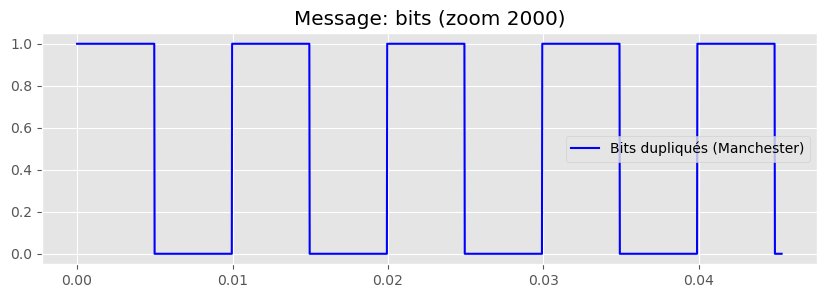

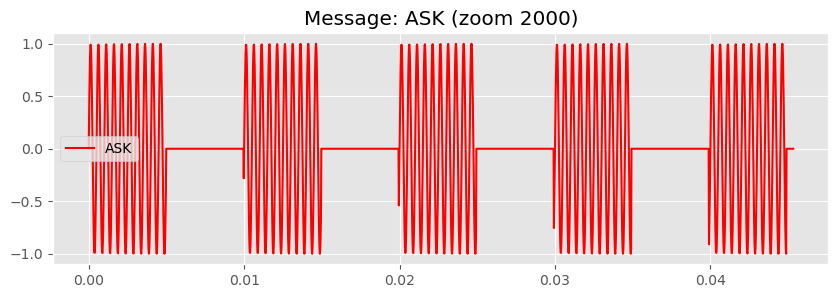

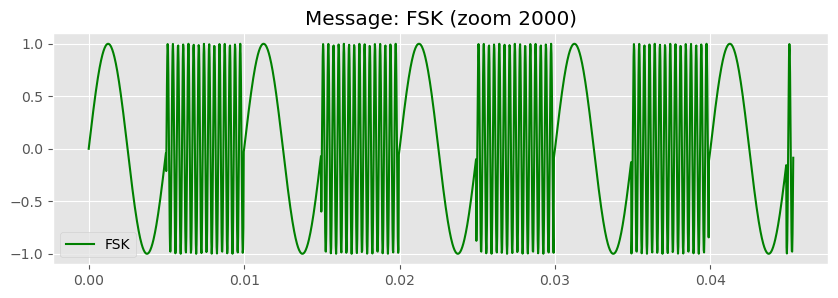


=== PHASE 2 : RÉCEPTION DU MESSAGE ===
Message final reçu : jjj

=== PHASE 3 : ÉMISSION D'UN ACK (HALF-DUPLEX) ===
Lecture audio du signal ASK (ACK_ASK.csv et ACK_ASK.wav)
Lecture audio du signal FSK (ACK_FSK.csv et ACK_FSK.wav)
Lecture audio du signal stéréo (ACK_stereo.wav)


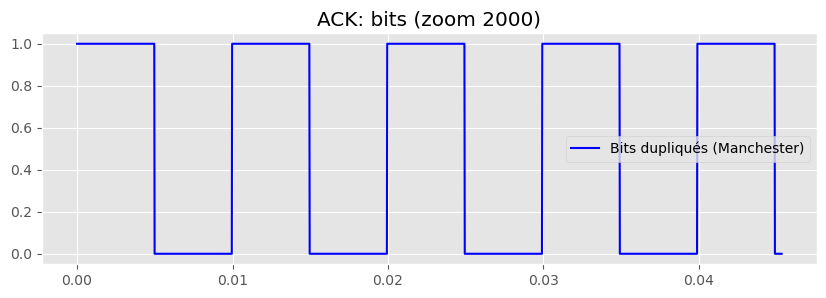

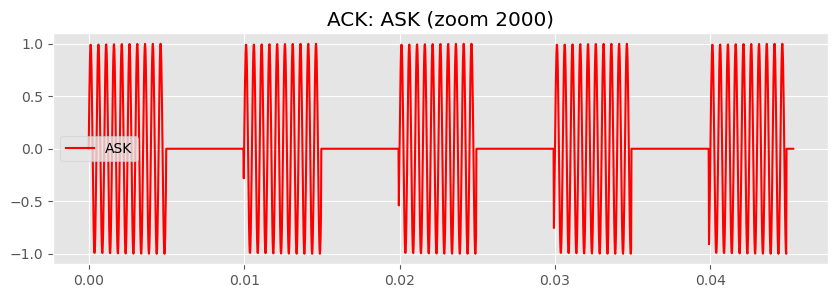

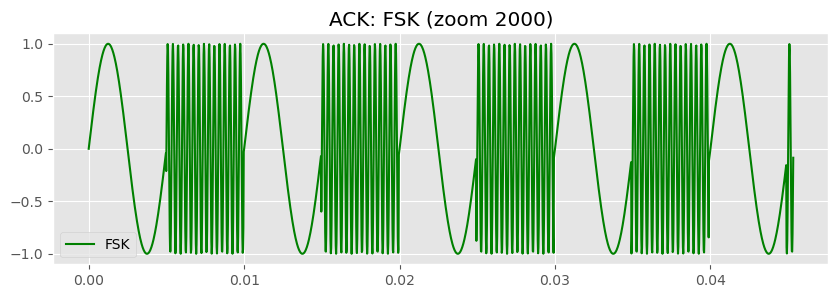


=== PHASE 4 : RÉCEPTION DE L'ACK ===
ACK final reçu : OK

=== Liaison half-duplex terminée ===


In [6]:
###############################################################################
#                          PROGRAMME PRINCIPAL
###############################################################################

if __name__ == "__main__":
    print("""
-------------------------------------
     DEMO HALF-DUPLEX AVEC ACK
-------------------------------------
""")
    send_message_and_receive_ack()


## Conclusion

En résumé, ce code illustre une chaîne de transmission et de réception en half‑duplex avec accusé de réception, intégrant plusieurs étapes essentielles :

- **Émission :** conversion ASCII, calcul du CRC, construction de trame, codage Manchester, modulation ASK/FSK, sauvegarde en CSV et WAV, lecture audio.
- **Réception :** démodulation (via intégration sur des blocs), décodage Manchester, extraction de la trame, vérification du CRC, et reconversion en message ASCII.
- **Communication half‑duplex :** après réception correcte du message, un ACK est généré et échangé de la même manière pour confirmer la bonne réception.

Ce code est un excellent exemple pédagogique de la mise en œuvre d’un système de communication numérique complet en simulation, intégrant à la fois le traitement du signal, la modulation/démodulation et la vérification d’intégrité.